## Music Recomedation system
Disclaimer: This project is largly inspired by VATSAl MAVANI's Music Recommendation System using Spotify Dataset on kaggle, link: https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset/notebook. Parts of my notebook is directly copied from his project and some parts have undergone larger changes by me. I have also utilised ChatGPT for this project, mostly as a means for problem solving and troubleshooting.

I wanted to explore how to make a reccomendation system and found the notebook quite helpful. The framework in this code is largely based on his work, although i have implemented some changes. Most notibly i made it an important factor that the recommended songs contained a similar genre as the suggested one. This was done as i felt the other version mostly suggested songs with similar sound signatures which often did not macth the vibe and tone i was looking for in recommendations. I also only input single song suggestions as i felt like this provides better reccomendations. Creating a mean vector is a viable soultion however if they dispare largly in sound signature the recommenadtions would worsen.

I have no real reason to include the data exploration and plots, VATSAl MAVANI's notebook uses them as a means to figure out what is important in order to get good song recommendations. His conclution is that songs with similar sounds tend to be from similar periods and genres, this is his reasonning behind using distances in a vector space as the model for song recommendation. I agree with this but put a larger emphasis on the importance of genre. This causes the recommendations to rely heavily on spotifys own labeling as the included dataset does not have this column. This method is probably innefficient and could be improved, it also requires a large amount of serches using the spotify API, which has a Max Retries limit. 

In [1]:
# Importing packages and files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from yellowbrick.target import FeatureCorrelation
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

music = pd.read_csv("data.csv.zip")
music_by_genre = pd.read_csv("data_by_genres.csv")
music_by_year = pd.read_csv("data_by_year.csv")

### Data Exploration

In [2]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [3]:
music_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [4]:
music_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [5]:
# Removing duplicate rows, based of same name, year and artist
music = music.drop_duplicates(["year", "artists", "name"])
len(music)

164794

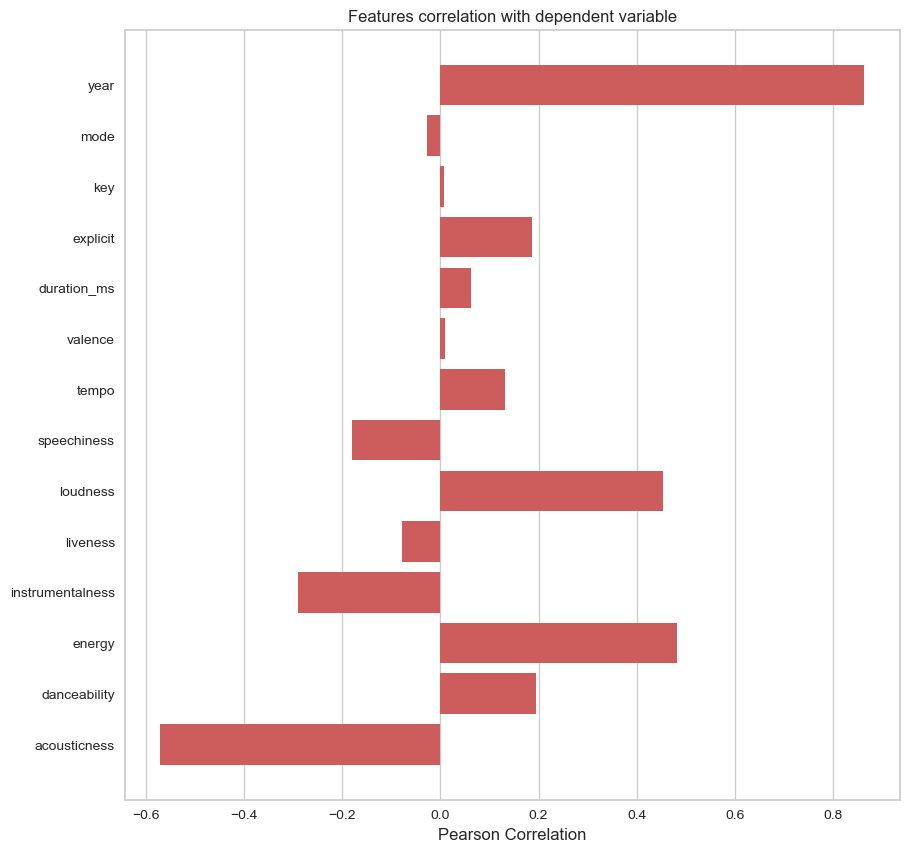

In [6]:
# A plot showing variable correlation with popularity
feature_names = ["acousticness", "danceability", "energy", "instrumentalness",
       "liveness", "loudness", "speechiness", "tempo", "valence","duration_ms","explicit","key","mode","year"]

X, y = music[feature_names], music["popularity"]

features = np.array(feature_names)

visualizer = FeatureCorrelation(labels=features, color="indianred")

plt.rcParams["figure.figsize"]=(10,10)
visualizer.fit(X, y)   
visualizer.show()
plt.show()

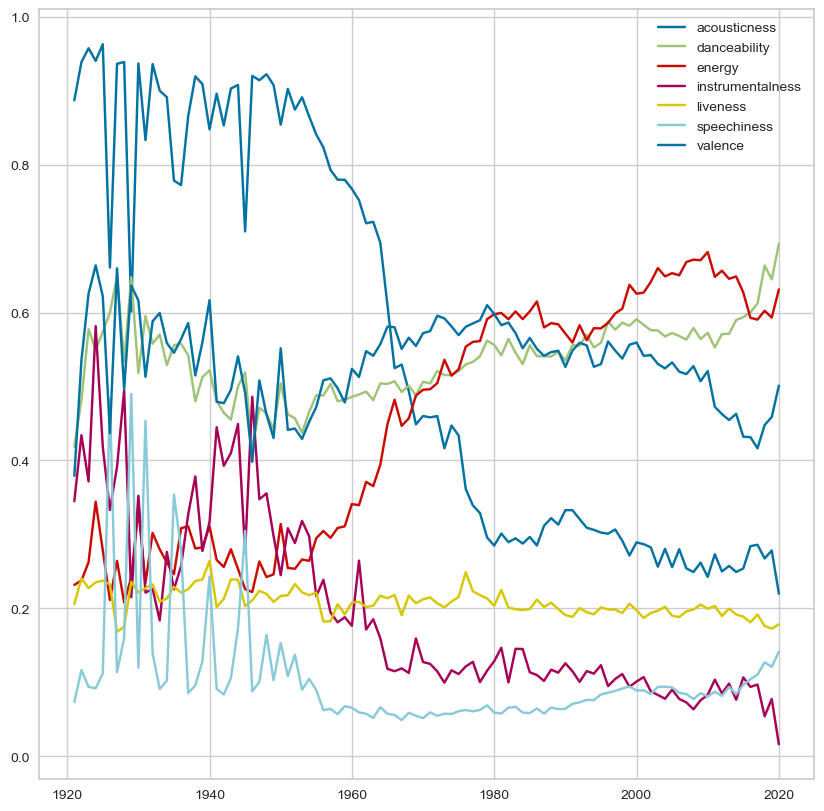

In [7]:
# A plot showing changes in sound signatures over time
sound_signatures = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "valence"]

fig = plt.plot(music_by_year["year"], music_by_year[sound_signatures])
plt.legend(sound_signatures)
plt.show()

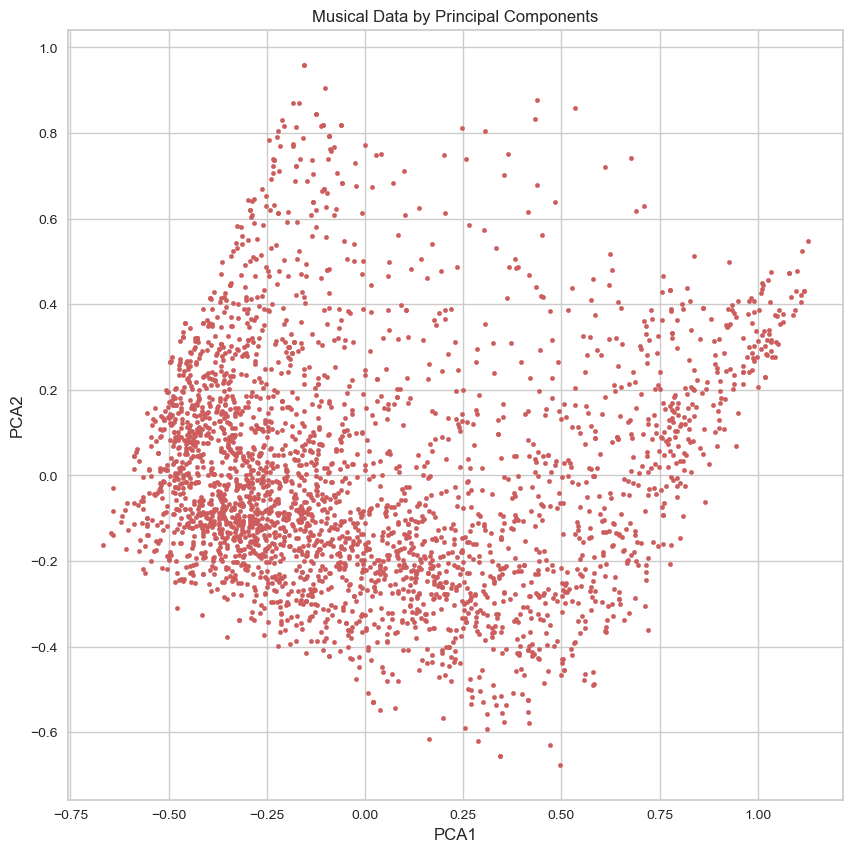

In [8]:
# Looking into the spread of the two first Principal Components
X = music_by_genre[sound_signatures]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
music_pca = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2"])

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(music_pca["PCA1"], music_pca["PCA2"], c="indianred", s=10)
plt.title("Musical Data by Principal Components")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


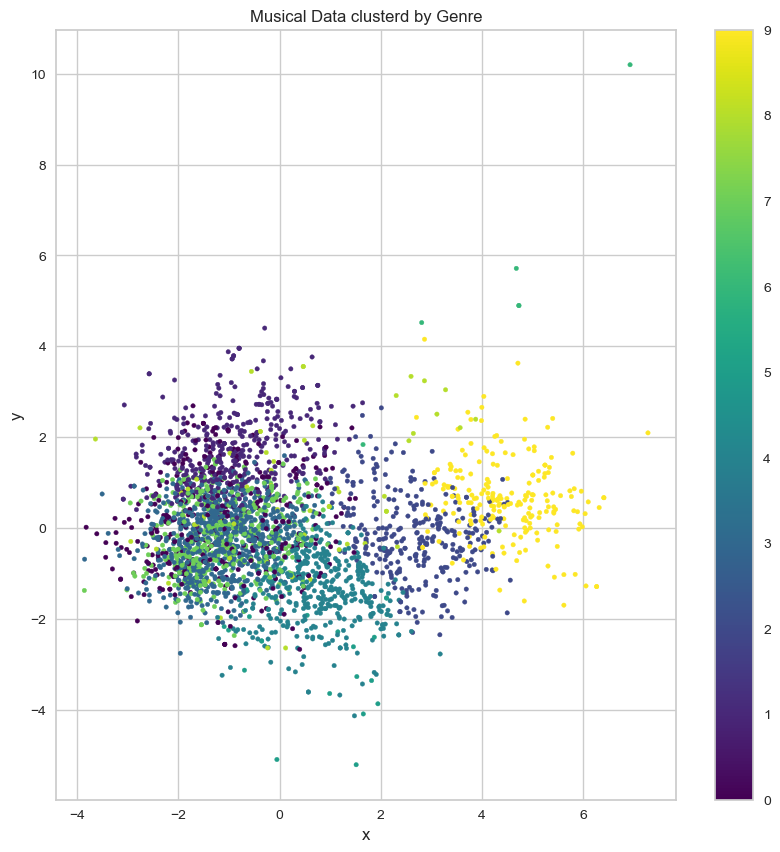

In [9]:
# A cluster analysis by genre using PCA components
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))]) 
X = music_by_genre.select_dtypes(np.number)
cluster_pipeline.fit(X)
music_by_genre['cluster'] = cluster_pipeline.predict(X)

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
genre_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = music_by_genre['genres']
projection['cluster'] = music_by_genre['cluster']

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(projection["x"], projection["y"], c=projection['cluster'], cmap="viridis", s=10)
plt.colorbar()
plt.title("Musical Data clusterd by Genre")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Song recommender

In [13]:
song_cluster_pipeline = Pipeline([("scaler", StandardScaler()), ("kmeans", KMeans(n_clusters=20, 
                                   verbose=False))], verbose=False)

X = music.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="your client_id", client_secret="your secret key"))


In [14]:
# searches for a song based on its name and release year. Returns a df with various audio features.
def search_spotify_database(name, year):
    
    results = sp.search(q= "track: {} year: {}".format(name,year), limit=1)

    if results["tracks"]["items"] == []:
        return None

    results = results["tracks"]["items"][0]
    track_id = results["id"]
    audio_features = sp.audio_features(track_id)[0]

    song_data = pd.DataFrame({"name": [name], "year": [year], "explicit": [int(results["explicit"])], 
                              "duration_ms": [results["duration_ms"]], "popularity": [results["popularity"]]})

    # Extract genres of associated artists
    artist_ids = [artist["id"] for artist in results["artists"]]
    artists = sp.artists(artist_ids)
    genres = set()

    artist_names = [] 
    for artist in artists["artists"]:
        genres.update(artist.get("genres", []))
        artist_names.append(artist["name"])
    song_data["genres"], song_data["artists"]  = [list(genres)], [artist_names]

    for key, value in audio_features.items():
        song_data[key] = value

    return song_data

def get_mean_vector(song):
    
    song_data = search_spotify_database(song[0], song[1]) # Retrieve song data using
        
    if song_data is None: # Print statement if song is not found
        print("Warning: ", song[0]," does not exist in Spotify or in database.")
    elif song_data["genres"] is None or song_data["genres"].empty:
        print("Unfortunatly", song[0], "has no genre data in the spotify database.")
            
    # Extract numeric features from the song data and create a matrix from the list of song vectors 
    song_matrix = np.array(list(song_data[number_cols].values))
    song_center = np.mean(song_matrix, axis=0) # Calculate the mean vector along axis 0 (columns)

    return song_center, song_data 

def recommendation_distances(song, spotify_data):
   
    # Get the mean vector of the provided song list
    song_center, song_data = get_mean_vector(song)
    
    # Scale the data using the pipeline's scaler
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    
    # Calculate cosine distances between the mean vector and the scaled data
    distances = cdist(scaled_song_center, scaler.transform(spotify_data[number_cols]), "cosine")
    
    # Get the indices of the closest songs
    pot_song = spotify_data.iloc[list(np.argsort(distances)[:, :100][0])]
    pot_song = pot_song[~pot_song["name"].isin(song_data["name"])] # Removing itself from the recomendations
    pot_song = pot_song.reset_index(inplace=False) # Reseting index
   
    return pot_song

def potential_to_recommended(song, spotify_data):

    pot_song = recommendation_distances(song, spotify_data)
    song_data = get_mean_vector(song)[1]
 
    i = 0
    rec_songs = pd.DataFrame(columns=pot_song.columns)

    for j in range(len(pot_song)):
        pot_data = search_spotify_database(pot_song["name"][j], pot_song["year"][j])
        
        if pot_data is not None and not pot_data["genres"].empty: # Check if the song and genre data is available   

            # Check if the genre of the recommended song matches the genre of the suggested song
            for genre in pot_data["genres"][0]:
                if genre in song_data["genres"][0]:
                    rec_songs = rec_songs.append(pot_data, ignore_index=True) # Add the recommended song to the list
                    i += 1

            if i >= 10:
                break
    
    return rec_songs


def song_recommendation(song, spotify_data):
    metadata_cols = ["name", "artists", "year"]
    # Retrieve recommended songs from the Spotify data
    rec_songs = potential_to_recommended(song, spotify_data)
    return rec_songs[metadata_cols]

In [16]:
song_recommendation(["Fix You", 2005],  music)

,name,artists,year
0,Fine Line,[Harry Styles],2019
1,Christmas Lights,[Coldplay],2010
2,Christmas Lights,[Coldplay],2010
3,Stop Crying Your Heart Out,[Oasis],2002
4,When We Were Young,[Adele],2016
5,The Only Exception,[Paramore],2009
6,Find The River,[R.E.M.],1992
7,Black Beauty,[Lana Del Rey],2014
8,I Always Wanna Die (Sometimes),[The 1975],2018
9,The Archer,[Taylor Swift],2019


##### Possible Project Improvements 

- Remove the need to search for genre data on spotify, and make the searches more efficient.
- Handle songs where the genre data is empty
- Solve duplicate songs in output
- Expand to cover several suggestion songs